In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import torch.quantization
import torch.nn.utils.prune as prune
import random

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


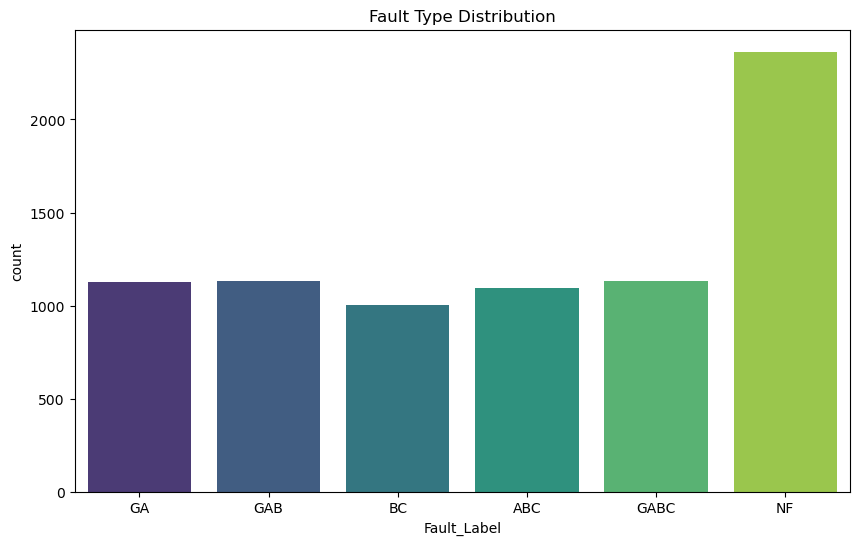

In [31]:
# Load Dataset
df = pd.read_csv('classData.csv')

# 1. Vectorized Fault Labeling based on G, A, B, C columns
df['Fault_Label'] = df[['G', 'A', 'B', 'C']].dot(df[['G', 'A', 'B', 'C']].columns).replace('', 'NF')

# 2. Visualization - Only Class Distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Fault_Label', data=df, palette='viridis', hue='Fault_Label', legend=False)
plt.title('Fault Type Distribution')
plt.show()

In [20]:
# Encoding Labels
le = LabelEncoder()
y_all = le.fit_transform(df['Fault_Label'])
X_all_raw = df[['Ia', 'Ib', 'Ic', 'Va', 'Vb', 'Vc']].values

# Parameters
WINDOW_SIZE = 50
STEP = 10

def create_sequences(data, labels, w, s):
    sequences = []
    seq_labels = []
    for i in range(0, len(data) - w, s):
        # Transpose to get (Channels, Sequence_Length) -> (6, 50)
        sequences.append(data[i:i+w].T)
        # Label is the label at the end of the window
        seq_labels.append(labels[i+w-1])
    return np.array(sequences), np.array(seq_labels)

# Generate Sequences first
X_seq, y_seq = create_sequences(X_all_raw, y_all, WINDOW_SIZE, STEP)

# Split Data (80% Train, 20% Test)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, stratify=y_seq, random_state=42
)

# Standard Scaling (Fit on Train, Apply to Test to avoid leakage)
# Note: We need to reshape to 2D for scaler, then back to 3D
scaler = StandardScaler()

# Reshape: (N, 6, 50) -> (N*50, 6) just to fit scaler on channel statistics
N_train, C, L = X_train_raw.shape
X_train_flat = X_train_raw.transpose(0, 2, 1).reshape(-1, C)
scaler.fit(X_train_flat)

# Transform Train
X_train_scaled = scaler.transform(X_train_flat).reshape(N_train, L, C).transpose(0, 2, 1)

# Transform Test
N_test, _, _ = X_test_raw.shape
X_test_flat = X_test_raw.transpose(0, 2, 1).reshape(-1, C)
X_test_scaled = scaler.transform(X_test_flat).reshape(N_test, L, C).transpose(0, 2, 1)

# Create Loaders
train_loader = DataLoader(TensorDataset(torch.FloatTensor(X_train_scaled), torch.LongTensor(y_train)), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(torch.FloatTensor(X_test_scaled), torch.LongTensor(y_test)), batch_size=64, shuffle=False)

print(f"Train Shape: {X_train_scaled.shape} | Test Shape: {X_test_scaled.shape}")

Train Shape: (625, 6, 50) | Test Shape: (157, 6, 50)


In [21]:
class FaultCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv1d(in_channels=6, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            
            # Block 2
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),
            
            # Block 3
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
        
        # Calculate size after pooling: 50 -> 25 -> 12 -> 6
        self.flatten_size = 128 * 6 
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flatten_size, 256),
            nn.ReLU(),
            nn.Dropout(0.5), # Dropout to prevent overfitting
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = FaultCNN(len(le.classes_)).to(device)
print(model)

FaultCNN(
  (features): Sequential(
    (0): Conv1d(6, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=768, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=Fal

Starting Training for 25 epochs...
Current Learning Rate: 0.001
Current Learning Rate: 0.001
Current Learning Rate: 0.001
Current Learning Rate: 0.001
Current Learning Rate: 0.001
Epoch 5/25 | Loss: 0.3952 | Val Acc: 79.62%
Current Learning Rate: 0.001
Current Learning Rate: 0.001
Current Learning Rate: 0.001
Current Learning Rate: 0.001
Current Learning Rate: 0.001
Epoch 10/25 | Loss: 0.3080 | Val Acc: 82.80%
Current Learning Rate: 0.001
Current Learning Rate: 0.001
Current Learning Rate: 0.001
Current Learning Rate: 0.001
Current Learning Rate: 0.001
Epoch 15/25 | Loss: 0.2550 | Val Acc: 82.17%
Current Learning Rate: 0.001
Current Learning Rate: 0.001
Current Learning Rate: 0.001
Current Learning Rate: 0.001
Current Learning Rate: 0.001
Epoch 20/25 | Loss: 0.2465 | Val Acc: 80.25%
Current Learning Rate: 0.001
Current Learning Rate: 0.001
Current Learning Rate: 0.0005
Current Learning Rate: 0.0005
Current Learning Rate: 0.0005
Epoch 25/25 | Loss: 0.2214 | Val Acc: 80.89%


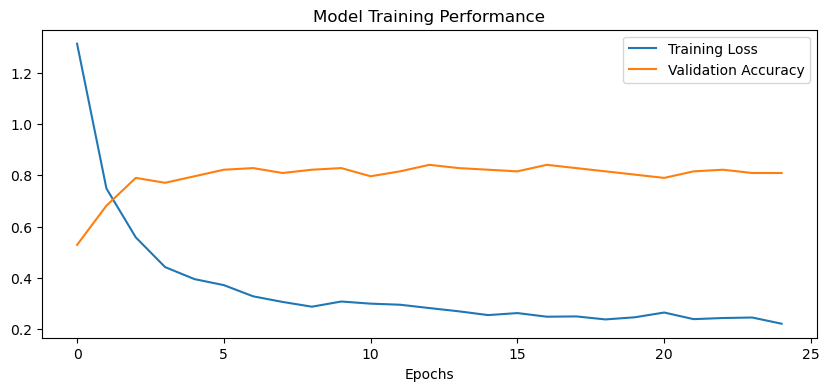

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Scheduler helps improve evaluation score by lowering LR when loss plateaus
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
train_losses = []
val_accuracies = []

epochs = 25
print(f"Starting Training for {epochs} epochs...")

for epoch in range(epochs):
    model.train()
    running_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    
    # Validation loop
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_val, y_val in test_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            preds = model(X_val).argmax(1)
            correct += (preds == y_val).sum().item()
            total += y_val.size(0)
    
    val_acc = correct / total
    val_accuracies.append(val_acc)
    
    scheduler.step(avg_loss)
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Current Learning Rate: {current_lr}")
    
    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f} | Val Acc: {val_acc:.2%}")

# Plot Training Curve
plt.figure(figsize=(10,4))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title("Model Training Performance")
plt.xlabel("Epochs")
plt.legend()
plt.show()

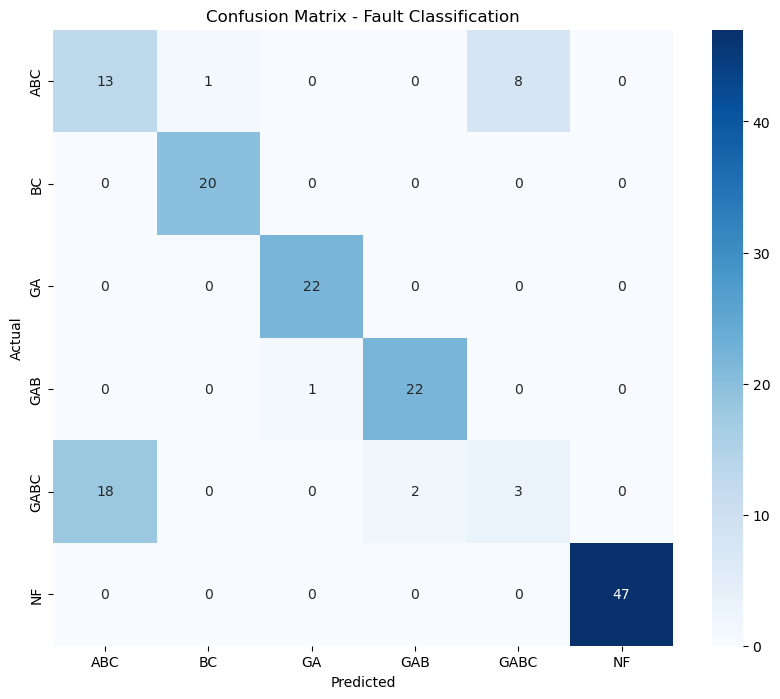

              precision    recall  f1-score   support

         ABC       0.42      0.59      0.49        22
          BC       0.95      1.00      0.98        20
          GA       0.96      1.00      0.98        22
         GAB       0.92      0.96      0.94        23
        GABC       0.27      0.13      0.18        23
          NF       1.00      1.00      1.00        47

    accuracy                           0.81       157
   macro avg       0.75      0.78      0.76       157
weighted avg       0.79      0.81      0.79       157



In [23]:
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        preds = model(X_batch).argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_targets.extend(y_batch.numpy())

# Confusion Matrix
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Fault Classification')
plt.show()

# Detailed Report
print(classification_report(all_targets, all_preds, target_names=le.classes_))

In [24]:
# 1. Quantization (Reduces model size)
# Note: PyTorch dynamic quantization usually works on CPU
model_cpu = model.to('cpu')
quantized_model = torch.quantization.quantize_dynamic(
    model_cpu, {nn.Linear}, dtype=torch.qint8
)

def get_size(m):
    torch.save(m.state_dict(), "temp.p")
    size = os.path.getsize("temp.p")
    os.remove("temp.p")
    return size / 1024 # KB

print(f"Original Model Size: {get_size(model):.2f} KB")
print(f"Quantized Model Size: {get_size(quantized_model):.2f} KB")

# 2. Pruning (Sparsity)
# Prune 30% of connections in the first linear layer
layer_to_prune = model.classifier[1]
prune.l1_unstructured(layer_to_prune, name="weight", amount=0.3)
prune.remove(layer_to_prune, 'weight') # Make pruning permanent

print("Pruning applied to classifier layer.")
# Move model back to device if needed
model = model.to(device)

Original Model Size: 908.56 KB
Quantized Model Size: 329.53 KB
Pruning applied to classifier layer.


C:\Users\Laksh\AppData\Local\Temp\ipykernel_17664\901441719.py:4: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  quantized_model = torch.quantization.quantize_dynamic(


In [32]:
import gradio as gr

# Organize test samples by class for simulation
samples_by_class = {label: [] for label in le.classes_}
for i, label_idx in enumerate(y_test):
    label_str = le.classes_[label_idx]
    samples_by_class[label_str].append(i)

def run_simulation(fault_type):
    # 1. Select a random sample of the requested fault type from test set
    if len(samples_by_class[fault_type]) == 0:
        return None, "No test samples found for this class."
    
    idx = random.choice(samples_by_class[fault_type])
    input_data = X_test_scaled[idx] # Shape (6, 50)
    
    # 2. Predict
    model.eval()
    tensor_in = torch.FloatTensor(input_data).unsqueeze(0).to(device)
    with torch.no_grad():
        logits = model(tensor_in)
        probs = torch.nn.functional.softmax(logits, dim=1)[0].cpu().numpy()
        pred_idx = logits.argmax(1).item()
    
    pred_label = le.classes_[pred_idx]
    
    # 3. Create Plots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
    
    # Plot Waveforms
    time_steps = np.arange(50)
    # Plot Currents (First 3 channels)
    ax1.plot(time_steps, input_data[0], label='Ia')
    ax1.plot(time_steps, input_data[1], label='Ib')
    ax1.plot(time_steps, input_data[2], label='Ic')
    ax1.set_title(f"Current Waveforms (Scaled) - True Class: {fault_type}")
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    
    # Plot Prediction Confidence
    colors = ['green' if c == pred_label else 'gray' for c in le.classes_]
    ax2.bar(le.classes_, probs, color=colors)
    ax2.set_ylim(0, 1)
    ax2.set_title(f"AI Prediction Confidence (Predicted: {pred_label})")
    ax2.set_ylabel("Probability")
    
    plt.tight_layout()
    return fig

# Setup Gradio Interface
with gr.Blocks(title="ABB Power Systems - Fault Detector") as demo:
    gr.Markdown("# ABB  High-Voltage Line Fault Detector")
    gr.Markdown("Select a fault type to simulate real-time detection using the 1D-CNN model.")
    
    with gr.Row():
        with gr.Column():
            dropdown = gr.Dropdown(choices=list(le.classes_), value="NF", label="Simulate Fault Type")
            btn = gr.Button("Inject unique waveform", variant="primary")
        
        with gr.Column():
            plot_output = gr.Plot(label="Analysis and prediction")
    
    btn.click(fn=run_simulation, inputs=dropdown, outputs=plot_output)

demo.launch(share=True)

* Running on local URL:  http://127.0.0.1:7869

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.
